<a href="https://colab.research.google.com/github/YanhuaZhang516/memory-representation-pomdp/blob/main/GridEnvLstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.0
!apt install swig cmake libopenmpi-dev zlib1g-dev
import stable_baselines
stable_baselines.__version__

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


'2.10.0'

In [19]:
tensorflow_version

Currently selected TF version: 1.x
Available versions:
* 1.x
* 2.x


In [20]:
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import MlpLstmPolicy

In [21]:
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines.common import set_global_seeds, make_vec_env
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.policies import *
from stable_baselines.common.env_checker import check_env

import matplotlib.pyplot as plt
import seaborn as sns
# sns test
sns.set_style("darkgrid")

In [22]:
import tensorflow as tf
import keras
import copy

In [23]:
from keras.models import load_model

In [38]:
from random import random
from gym import Env
import gym
from gym import spaces
from gridworld2 import *
from gridworldRNN import *

In [40]:
import pandas as pd

In [25]:
import sys
sys.setrecursionlimit(10000)

In [26]:
# redefine the model with lstm 
class GridWorldEnvLstm(GridWorldEnvRnn, gym.Wrapper):
    def __init__(self, n_width, n_height, u_size, default_type, max_episode_steps,default_reward):

        super(GridWorldEnvLstm, self).__init__(n_width=n_width,
                                              n_height=n_height,
                                              u_size=u_size,
                                              default_type=default_type,
                                              default_reward=default_reward,
                                              max_episode_steps=max_episode_steps
                                              )
        # Todo
        self.reward = default_reward
        self.action = None
        self.obs_matrix = None
        self.state = None
        self.predicted_state = None
      
        self.observation_space = spaces.Discrete(self.n_width* self.n_height)

        #self.observation_space = spaces.Discrete(self.n_height*self.n_width)

        self.start = (2, 2)
        self.end = (5, 6)


        # find the largest distance between the state and the end state for normalization:
        n_width_max = max([np.abs(i+2 - self.end[0]) for i in range(self.n_width-2)])
        n_height_max = max([np.abs(i+2 - self.end[1]) for i in range(self.n_height-2)])
        self.n_max = n_height_max+n_width_max

        # set a time limit
        self._max_episode_steps = max_episode_steps
        self._elapsed_steps = None

        # here we add initial queue to the new input part
        initial_input = np.array([0,1,0,0,1,0,0,1,1,1])
        initial_queue = []
        for i in range(1000):initial_queue.append(initial_input) 
        initial_queue = np.array(initial_queue).reshape((1,1000,10)) 
        self.input_queue = initial_queue

        # load the lstm model
        self.model_lstm = keras.models.load_model('my_lstm_model_2.0')


        # set the wall to the grid:
        index = []
        for i in range(self.n_width):
            index.append((i+1, 1, 1))
            index.append((i+1, self.n_width, 1))
            index.append((1, i+1, 1))
            index.append((self.n_width, i+1, 1))
        self.types = index
        self.refresh_setting()

        self.reset()


    def lstm_model(self,input):
        """
        :param input (array): [action,observation_matrix] with the shape(10,)
        for example(array): [obs,action]=[3, 0, 0, 1, 0, 0, 1, 0, 0, 1]
        :return: predicated state: [new_obst]=23 ; the number is in the range of [1,100]
        """
        
        self.input_queue[0][self._elapsed_steps]=input
        y_pred_label= self.model_lstm.predict(self.input_queue)[0][self._elapsed_steps]
        y_predicted = np.argmax(y_pred_label, axis=-1)
        # print(y_predicted)
        # print(input)
        # print(self._elapsed_steps)
        

        return y_predicted


    def step(self,action):
        assert self._elapsed_steps is not None, "cannot call env.step() before calling reset() "
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        ## to do the step part
        # add some noise here
        #r = random()
        # if r <= 0.2:
        #     self.action = self.action_space.sample()
        # else:
        #     self.action = action  # action for rendering
        self.action = action
        #  the env store the internal state
        old_x, old_y = self._state_to_xy(self.state)
        new_x, new_y = old_x, old_y

        if action == 0:
            new_x -= 1  # left
        elif action == 1:
            new_x += 1  # right
        elif action == 2:
            new_y += 1  # up
        elif action == 3:
            new_y -= 1  # down

        # boundary effect
        if new_x < 1: new_x = 1
        if new_x > self.n_width: new_x = self.n_width
        if new_y < 1: new_y = 1
        if new_y > self.n_height: new_y = self.n_height


        # wall effect:
        # when the type of grid is 1, it means that the object couldn't get in
        if self.grids.get_type(new_x, new_y) == 1: new_x, new_y = old_x, old_y

        # 修改状态，观测值
     
        self.state = self._xy_to_state(new_x, new_y)
        self.obs_matrix = self._xy_to_obs_matrix(new_x, new_y)
        # print("position is :", (new_x, new_y))
        # print("the state is:", self.state)
        # change the whole observation part
        
        
        # reward for the state(obs)
        self.reward = self.get_reward(new_x, new_y)

        # judge if the process is finished
        done = self._is_end_state(new_x, new_y)

        # 提供格子所在信息
        info = {"x": new_x, "y": new_y, "state":self.state,"grids": self.grids, "TimeLimit.truncated": False, "obs_matrix":self.obs_matrix}

        
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            info['TimeLimit.truncated'] = not done
            done = True
        
        x = np.hstack((self.action, self.obs_matrix))
        
        self.predicted_state = int(self.lstm_model(x))
        # print("for time:", self._elapsed_steps)
        # print("the predicted state:", self.predicted_state)
        # print("the real state:", self.state)


        return self.predicted_state, self.reward, done, info


    def reset(self):
        self.state = int(self._xy_to_state(self.start))
        self.obs_matrix = self._xy_to_obs_matrix(self.start)
        self.action = 0
        self._elapsed_steps = 0
        # Todo
        self.predicted_state = 12
        #self.input_queue = copy.deepcopy(self.initial_queue)
        initial_input = np.array([0,1,0,0,1,0,0,1,1,1])
        initial_queue = []
        for i in range(1000):initial_queue.append(initial_input) 
        initial_queue = np.array(initial_queue).reshape((1,1000,10)) 
        self.input_queue = copy.deepcopy(initial_queue)

        return self.predicted_state

In [27]:
# add evaluation module
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    
    for i in range(num_episodes):
        episode_rewards = []
        done = False  
        t=0     
        obs = env.reset()
        while not done :
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            #print("without noise:", action)
            # here, action, rewards and dones are arrays
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            t+=1

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [28]:
def train_batch(model):
  
  reward=[]
  for _ in range(10):
    start_time = time.time()
    model.learn(total_timesteps=1000)
    stamp1 = time.time()
    x = evaluate(model,num_episodes=50)
    stamp2 = time.time()
    reward.append(x)
    print("the learning time is:", stamp1-start_time)
    print("the evaluate time is:", stamp2-stamp1)

  return reward

In [29]:
def train_all(model,num):

  rewards = []
 
  for _ in range(num):
    # one batch for 10,000 steps
    r = train_batch(model)
    rewards+=r
    print(rewards[-1])
  
  return rewards

In [30]:
def reward_plot(reward):
  x=np.linspace(0, 1000*(len(reward)),len(reward),endpoint=True)
  plt.plot(x,reward,label='model1')

def reward_plot_two(reward1,reward2):
    if len(reward1)>len(reward2):num = len(reward2)
    else:num = len(reward1)
    
    x1=np.linspace(0, 1000*len(reward1),len(reward1),endpoint=True)
    x2=np.linspace(0, 1000*len(reward2),len(reward2),endpoint=True)
    plt.plot(x1,reward1,label='model1')
    plt.plot(x2,reward2)

def reward_plot_all(rewards):
  n = len(rewards)
  x=np.linspace(0, 1000*(len(rewards[0])-1),len(rewards[0])-1,endpoint=True)
  for _ in range(n):
    plt.plot(x, rewards[_][1:])

## Normal POMDP Enviroment with PPO2 model(MLP/LSTM)

In [31]:
class CustomLSTMPolicy(LstmPolicy):
  """
  for the default LstmPolicy :
    n_lstm:(int) the number of LSTM cells (default = 256) the number of hidden neurons
    layers:([int]) The size of the Neural network before the LSTM layer  (if None, default to [64, 64])
    net_arch:(list) Specification of the actor-critic policy network architecture. Notation similar to the
        format described in mlp_extractor but with additional support for a 'lstm' entry in the shared network part.
  """
  def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, layers=None, n_lstm=256, reuse=False, **_kwargs):
        super().__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm, layers, reuse,
                         net_arch=[8, 'lstm', dict(vf=[64], pi=[64])],
                         layer_norm=True, feature_extraction="mlp", **_kwargs)

In [32]:
env1 = GridWorldEnvRnn(n_width =10,n_height=10,
                       u_size=60,
                      default_reward=-1,
                      default_type= 0 ,
                      max_episode_steps=100)
env1.start= (2,2)
env1.end= (5,6)
# set the special reward for end
env1.grids.set_reward(env1.end[0], env1.end[1],0)
env1.refresh_setting()
check_env(env1)

In [ ]:
model1=PPO2('MlpPolicy',env1,verbose=0)

In [34]:
reward1 = train_all(model1, num=10)

Mean reward: -40.765 Num episodes: 50
the learning time is: 1.7538294792175293
the evaluate time is: 3.1103768348693848
Mean reward: -28.8375 Num episodes: 50
the learning time is: 1.1161589622497559
the evaluate time is: 2.338824987411499
Mean reward: -33.97 Num episodes: 50
the learning time is: 1.055830717086792
the evaluate time is: 2.7269766330718994
Mean reward: -34.45 Num episodes: 50
the learning time is: 1.0746448040008545
the evaluate time is: 2.7538371086120605
Mean reward: -36.4225 Num episodes: 50
the learning time is: 1.0423245429992676
the evaluate time is: 2.8890769481658936
Mean reward: -31.7475 Num episodes: 50
the learning time is: 1.0974781513214111
the evaluate time is: 2.536125898361206
Mean reward: -36.16 Num episodes: 50
the learning time is: 1.104158878326416
the evaluate time is: 2.924774169921875
Mean reward: -32.12 Num episodes: 50
the learning time is: 1.1230111122131348
the evaluate time is: 2.522298812866211
Mean reward: -34.3325 Num episodes: 50
the lear

In [41]:
d={'pomdp1':reward1}
df = pd.DataFrame(data=d)
df.to_csv('pomdp1')

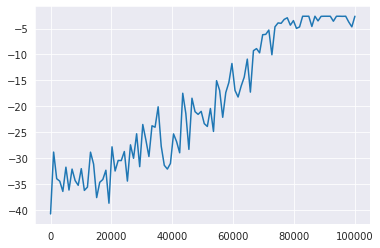

In [35]:
reward_plot(reward1)

In [46]:
from gridworldRNN import GridWorldPomdp1

In [47]:
env2 =GridWorldPomdp1(n_width =10,n_height=10,
                       u_size=60,
                      default_reward=-1,
                      max_episode_steps=100,
                      default_type= 0 )

env2.grids.set_reward(env2.end[0], env2.end[1],0)
env2.refresh_setting()
check_env(env2)

In [48]:
model2=PPO2('MlpPolicy',env2,verbose=0)

In [49]:
reward2 = train_all(model2, num=10)

Mean reward: -36.235 Num episodes: 50
the learning time is: 1.3704450130462646
the evaluate time is: 2.989893913269043
Mean reward: -31.905 Num episodes: 50
the learning time is: 1.0756065845489502
the evaluate time is: 2.673727512359619
Mean reward: -37.9825 Num episodes: 50
the learning time is: 1.1300885677337646
the evaluate time is: 3.0799877643585205
Mean reward: -30.8475 Num episodes: 50
the learning time is: 1.0692882537841797
the evaluate time is: 2.5124001502990723
Mean reward: -32.9 Num episodes: 50
the learning time is: 1.1341254711151123
the evaluate time is: 2.588684320449829
Mean reward: -35.98 Num episodes: 50
the learning time is: 1.0193336009979248
the evaluate time is: 2.682620048522949
Mean reward: -30.8825 Num episodes: 50
the learning time is: 1.110917568206787
the evaluate time is: 2.4769606590270996
Mean reward: -34.085 Num episodes: 50
the learning time is: 1.0552873611450195
the evaluate time is: 2.664743661880493
Mean reward: -32.8675 Num episodes: 50
the lea

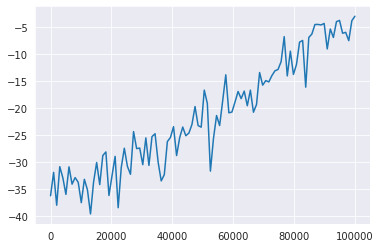

In [50]:
reward_plot(reward2)

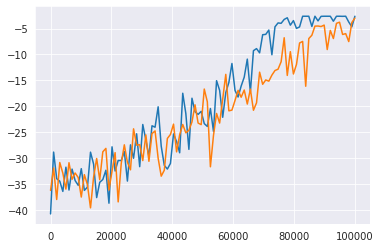

In [51]:
reward_plot_two(reward1,reward2)

new Env with LSTM in PPO2

In [57]:
env = GridWorldEnvLstm(n_width=10, n_height=10, u_size=60, default_type=0, max_episode_steps=100, default_reward=-1)
env.start = (2, 2)
env.end = (5, 6)
env.refresh_setting()
check_env(env)


In [58]:
model =  PPO2('MlpPolicy',env,verbose=0)

In [59]:
reward_new_lstm = train_all(model, num=3)

Mean reward: -37.9625 Num episodes: 50
the learning time is: 68.68302178382874
the evaluate time is: 255.79322028160095
Mean reward: -30.375 Num episodes: 50
the learning time is: 67.61076855659485
the evaluate time is: 218.95899271965027
Mean reward: -34.28 Num episodes: 50
the learning time is: 67.31893634796143
the evaluate time is: 249.36490893363953
Mean reward: -25.3275 Num episodes: 50
the learning time is: 70.80469965934753
the evaluate time is: 191.01743149757385
Mean reward: -24.8075 Num episodes: 50
the learning time is: 66.93001627922058
the evaluate time is: 183.3709201812744
Mean reward: -28.425 Num episodes: 50
the learning time is: 65.69499897956848
the evaluate time is: 207.81642150878906
Mean reward: -24.4625 Num episodes: 50
the learning time is: 67.04158735275269
the evaluate time is: 180.59834599494934
Mean reward: -16.9175 Num episodes: 50
the learning time is: 66.15634846687317
the evaluate time is: 130.4826946258545
Mean reward: -16.1525 Num episodes: 50
the lea

In [70]:
reward_new_lstm += train_all(model, num=3)

Mean reward: -2.625 Num episodes: 50
the learning time is: 66.97302508354187
the evaluate time is: 25.71611261367798
Mean reward: -2.625 Num episodes: 50
the learning time is: 66.41113305091858
the evaluate time is: 26.059818267822266
Mean reward: -2.625 Num episodes: 50
the learning time is: 67.39410066604614
the evaluate time is: 25.83296251296997
Mean reward: -2.625 Num episodes: 50
the learning time is: 65.93307638168335
the evaluate time is: 25.69739556312561
Mean reward: -2.625 Num episodes: 50
the learning time is: 65.74672436714172
the evaluate time is: 25.781713485717773
Mean reward: -2.625 Num episodes: 50
the learning time is: 65.98582768440247
the evaluate time is: 25.811255931854248
Mean reward: -2.625 Num episodes: 50
the learning time is: 65.95602560043335
the evaluate time is: 25.44912075996399
Mean reward: -2.625 Num episodes: 50
the learning time is: 66.35448217391968
the evaluate time is: 26.121586084365845
Mean reward: -2.625 Num episodes: 50
the learning time is: 6

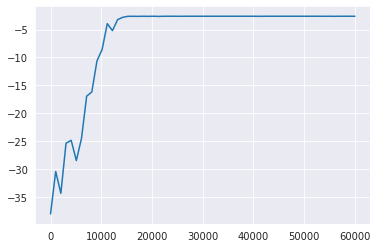

In [71]:
reward_plot(reward_new_lstm)

In [74]:
print(len(reward_new_lstm))

60


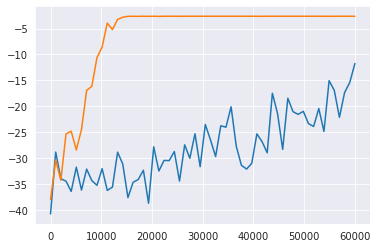

In [75]:
reward_plot_two(reward1[:60],reward_new_lstm)

In [87]:
from gridworld2 import GridWorldEnv

In [98]:
class GridWorldEnv2(GridWorldEnv):

  def __init__(self, n_width: int = 7,
                 n_height: int = 7,
                 u_size=40,
                 default_reward: float = -1,
                 default_type=0,
                 max_episode_steps=100
                 ):
    
    
    super(GridWorldEnv2, self).__init__(n_width=n_width,
                                              n_height=n_height,
                                              u_size=u_size,
                                              default_type=default_type,
                                              default_reward=default_reward,
                                              max_episode_steps=max_episode_steps
                                              )
    
    self.start = (2, 2)
    self.end = (5, 6)

    # find the largest distance between the state and the end state for normalization:
    self.n_width_max = max([np.abs(i + 2 - self.end[0]) for i in range(self.n_width - 2)])
    self.n_height_max = max([np.abs(i + 2 - self.end[1]) for i in range(self.n_height - 2)])
    self.n_max = self.n_height_max + self.n_width_max


    # set the wall to the grid:
    index = []
    for i in range(self.n_width):
        index.append((i + 1, 1, 1))
        index.append((i + 1, self.n_width, 1))
        index.append((1, i + 1, 1))
        index.append((self.n_width, i + 1, 1))
    self.types = index
    self.refresh_setting()

    self.reset()

  def get_reward(self, x, y):
    # redefine the end
    l_1 = np.abs(x-self.end[0]) + np.abs(y-self.end[1])
    reward = -1*l_1/self.n_max

    return reward

  def step(self, action):
    assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
    self.action = action  # action for rendering
    # add some noise here
    r = random()
    if r <= 0.2:
        self.action = self.action_space.sample()

    old_x, old_y = self._state_to_xy(self.state)
    new_x, new_y = old_x, old_y

    if action == 0:
        new_x -= 1  # left
    elif action == 1:
        new_x += 1  # right
    elif action == 2:
        new_y += 1  # up
    elif action == 3:
        new_y -= 1  # down

    # boundary effect
    if new_x < 1: new_x = 1
    if new_x > self.n_width: new_x = self.n_width
    if new_y < 1: new_y = 1
    if new_y > self.n_height: new_y = self.n_height

    # wall effect:
    # when the type of grid is 1, it means that the object couldn't get in
    if self.grids.get_type(new_x, new_y) == 1:
        new_x, new_y = old_x, old_y

    self.reward = self.get_reward(new_x, new_y)
    done = self._is_end_state(new_x, new_y)
    ### 这里修改状态
    self.state = self._xy_to_state(new_x, new_y)

    # 提供格子所在信息
    info = {"x": new_x, "y": new_y, "grids": self.grids, "TimeLimit.truncated": False}

    self._elapsed_steps += 1

    if self._elapsed_steps >= self._max_episode_steps:
        info['TimeLimit.truncated'] = not done
        done = True

    return self.state, self.reward, done, info
    


In [99]:
env_mlp = GridWorldEnv2(n_width=10, n_height=10, u_size=60, default_type=0, max_episode_steps=100, default_reward=-1)
env_mlp.start = (2, 2)
env_mlp.end = (5, 6)
env_mlp.refresh_setting()
check_env(env_mlp)

In [100]:
model_mlp =  PPO2('MlpPolicy',env_mlp,verbose=0)

In [101]:
reward_mlp = train_all(model_mlp, num=10)

Mean reward: -34.245 Num episodes: 50
the learning time is: 1.2633447647094727
the evaluate time is: 2.341547727584839
Mean reward: -34.1375 Num episodes: 50
the learning time is: 0.9509670734405518
the evaluate time is: 2.320821762084961
Mean reward: -29.4325 Num episodes: 50
the learning time is: 0.955829381942749
the evaluate time is: 2.085721254348755
Mean reward: -29.595 Num episodes: 50
the learning time is: 1.0151293277740479
the evaluate time is: 2.192387580871582
Mean reward: -31.3425 Num episodes: 50
the learning time is: 0.9647283554077148
the evaluate time is: 2.390864133834839
Mean reward: -25.0725 Num episodes: 50
the learning time is: 0.9458675384521484
the evaluate time is: 1.819136381149292
Mean reward: -24.99 Num episodes: 50
the learning time is: 0.9637022018432617
the evaluate time is: 1.739391803741455
Mean reward: -27.95 Num episodes: 50
the learning time is: 0.9614322185516357
the evaluate time is: 1.9032292366027832
Mean reward: -25.0525 Num episodes: 50
the lea

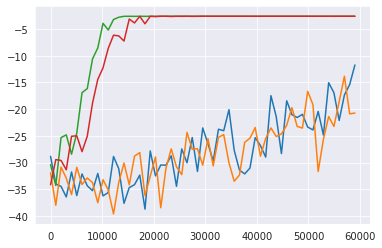

In [102]:
rewards=[reward1[:60], reward2[:60], reward_new_lstm, reward_mlp[:60]]
reward_plot_all(rewards)

In [104]:
d={'pomdp1':reward1[:60], 'pomdp2':reward2[:60], 'lstm':reward_new_lstm, 'mlp':reward_mlp[:60]}
df = pd.DataFrame(data=d)
df.to_csv('4models.csv')

### model save and loading

In [105]:
model.save('ppo2_lstm')

In [124]:
model_test = PPO2.load('ppo2_lstm')

In [127]:
# add evaluation module
def evaluate_env(model,env, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
   
    all_episode_rewards = []
    
    for i in range(num_episodes):
        episode_rewards = []
        done = False  
        t=0     
        obs = env.reset()
        while not done :
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            #print("without noise:", action)
            # here, action, rewards and dones are arrays
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            t+=1

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [129]:
reward_test = evaluate_env(model_test,env, num_episodes=10)

Mean reward: -2.625 Num episodes: 10
